# DC-EGM med Max's Model

## load packages and dependencies

In [1]:
#Dependencies
import jax.numpy as jnp
import numpy as np
from dcegm.pre_processing.setup_model import setup_model
import jax

from typing import Tuple

import pandas as pd
import matplotlib.pyplot as plt

from dcegm.sim_interface import get_sol_and_sim_func_for_model
from dcegm.simulation.sim_utils import create_simulation_df

from scipy.optimize import minimize

import statsmodels.api as sm

import os

import sys
sys.path.insert(0,"/Users/frederiklarsen/dcegm/Speciale")
sys.path.insert(1,"/Users/frederiklarsen/dcegm/")

from model_functions.utility import utility_functions
from model_functions.final_period_utility import final_period_utility
from model_functions.budget import budget_dcegm
from model_functions.state_space_functions import create_state_space_function_dict
from model_functions.compute_moments import compute_simulation_moments
from model_functions.compute_moments import compute_simulation_moments_with_ci
from model_functions.plots import plot_empirical_vs_simulated_with_ci
from first_step.mortality import prob_survival

from dcegm.interface import validate_exogenous_processes

# ── Configurating file-location -────────────────────────────────────────────────
DATA_DIR    = "/Users/frederiklarsen/Data"
FILE_UDD1   = os.path.join(DATA_DIR, "momenter/moments_udd1.txt")
FILE_UDD2   = os.path.join(DATA_DIR, "momenter/moments_udd2.txt")
FILE_UDD3   = os.path.join(DATA_DIR, "momenter/moments_udd3.txt")
Mortality   = os.path.join(DATA_DIR, "mortality.xlsx")
# ────────────────────────────────────────────────────────────────────────────────

##### Git Commit Hash ee6660e #####
##### Git Branch = origin(aux-budget) #####
# ────────────────────────────────────────────────────────────────────────────────


jax.config.update("jax_enable_x64", True)

MLE estimates: alpha1 = 0.000417, alpha2 = 0.099277


## Load Data 

In [2]:
# Read CSV
df_edu_1 = pd.read_csv(FILE_UDD1)
df_edu_2 = pd.read_csv(FILE_UDD2)
df_edu_3 = pd.read_csv(FILE_UDD3)
# read mortality and discard seoncd and third column
df_mort = pd.read_excel(Mortality, sheet_name="DOD", usecols=[0, 3])

# 2) standardize colomn name and remove _FREQ_ column
for df in (df_edu_1, df_edu_2, df_edu_3):
    # Rename ALDER → age
    if "ALDER" in df.columns:
        df.rename(columns={"ALDER": "age"}, inplace=True)
    # Remove _FREQ_-column if it exists
    if "_FREQ_" in df.columns:
        df.drop(columns=["_FREQ_"], inplace=True)


#df_edu_1

# ====================================================================================================================

# Structural Estimation

## Initiatal parameters - some are estimated above, the rest to be structuraly estimated

In [3]:
beta0, beta1, beta2 = np.loadtxt("/Users/frederiklarsen/dcegm/Speciale/first_step/wage_params_udd1.txt")

params_initial = {}
params_initial["interest_rate"] = 0.01
params_initial["sigma"] = 0.16218958 # income shock scale
params_initial["lambda"] = 0.91443668 # taste shock scale

# discount factor
params_initial["beta"] = 0.90535854

# parameters for the utility function
params_initial["rho"]=0.50092644 #0.76492381

# disutility of each hours choice
params_initial["gamma"]=jnp.array([0.82253966,1.5360604,1.93859858,1.45922689]) 


# wage parameters
params_initial["beta0"]=beta0
params_initial["beta1"]=beta1
params_initial["beta2"]=beta2


# Age component disutility
# params_initial["kappa1"]=0.06931974
params_initial["kappa2"]=0.00316552

# transsition cost
params_initial["phi"]=0.94614399

# mortality parameters
params_initial["alpha1"]=0.000417
params_initial["alpha2"]=0.099277

# bequest parameters
params_initial["b_scale"]=1.2133177
params_initial["xi"]=0.26926199


# labor market parameters
params_initial["eta_edu1"]=2.14443663


params=params_initial.copy()

## Options for model - Choices and states

In [4]:
n_periods = 55
choices = np.arange(5) # 5 choices
alpha1, alpha2 = np.loadtxt("/Users/frederiklarsen/dcegm/Speciale/first_step/mortality_params.txt")
options = {
    "model_params": {
        #"quadrature_points_stochastic": 5, 
        "n_quad_points_stochastic": 25,
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "hours": jnp.array([0,250,750,1300,1900]), #list 
        "max_hours": 1500,
        "start_age": 30,
        "inc_threshold": 6.0,
        "tax_base_rate": 0.37,
        "tax_top_rate": 0.5,
        "retirement_age": 67,
        "oap_base_amount":0.80328,
        "oap_max_supplement": 0.92940,
        "supp_threshold": 0.79300,
        "oap_threshold": 3.3592,
        "supp_reduction_rate": 0.309,
        "oap_reduction_rate": 0.3,
        "alpha1": alpha1, # independently estimated parameter for survival probability
        "alpha2": alpha2,  # independently estimated parameter for survival probability
        "max_init_experience": 5,
        "max_ret_period": 45, # Age 75
        "min_ret_period": 30, # Age 60
    },
    "state_space": {
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "continuous_states": {
            "wealth": np.linspace(0, 50, 20),
            "experience": jnp.linspace(0, 1, 5).astype(float) # 1 experince grid point, if experience can only go up by a year - more points if it is a fraction based on hours worked
        },
        "exogenous_processes": {
            "survival": {
                "transition": prob_survival,
                "states": [0, 1],
            },
        },
    },
}

### Setup the model

In [5]:
model = setup_model(
    options=options,
    state_space_functions=create_state_space_function_dict(),
    utility_functions=utility_functions,
    utility_functions_final_period=final_period_utility,
    budget_constraint=budget_dcegm,
)

State specific choice set not provided. Assume all choices are available in every state.
Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  50
Model setup complete.



In [12]:
# # validate model
# validate_exogenous_processes(model, params)

# ====================================================================================================================

## Initial values for simulating. 

In [6]:
# Select number of individuals for simulation
n_individuals = 10000

seed = 132
key = jax.random.PRNGKey(0)
n = n_individuals                        

# distribution of initial choices
labels = jnp.array([0, 1, 2, 3], dtype=jnp.int32)
probs  = jnp.array([0.25, 0.20, 0.25, 0.509])  # sums to 1.0

lagged_choice = jax.random.choice(
    key,
    a       = labels,
    shape   = (n,),
    p       = probs,
    replace = True
)
# set initial states for each individual
states_initial = {
    "period": jnp.zeros(n_individuals),       # Every individual starts at period 0 (age 30)
    "lagged_choice": lagged_choice,  # Every individual starts with choice 3 (work fulltime)
    "experience": jnp.full(n_individuals, 0.8).astype(float),  # Every individual starts with 5 years of experience
    "survival": jnp.ones(n_individuals), # Every individual starts with 1 (alive)
}

# Set wealth at beginning of period, which is the starting wealth for every individual. 
wealth_initial = jnp.full(n_individuals, 0.59)   # Every individual starts with 59k wealth - to be adjusted based on the actual moments

## Simulate model

In [7]:
sim_func_aux = get_sol_and_sim_func_for_model(
    model=model,
    states_initial=states_initial,
    wealth_initial=wealth_initial,
    n_periods=options["state_space"]["n_periods"],
    seed=seed,
)


In [8]:
output_dict_aux = sim_func_aux(params)

## Convert simulation results to DataFrame

In [9]:
df_sim = create_simulation_df(output_dict_aux["sim_dict"])

# =====================
# print all agents
# =====================
#df_sim

# =====================
# print a select agent
# =====================
df_sim.loc[(slice(None), 20),:] 

,,acc_exp,choice,consumption,experience,income_shock,labor_income,lagged_choice,lumpsum,net_labor,period_pension,...,taste_shocks_0,taste_shocks_1,taste_shocks_2,taste_shocks_3,taste_shocks_4,value_choice_0,value_choice_1,value_choice_2,value_choice_3,value_choice_4
period,agent,,,,,,,,,,,,,,,,,,,,,
0,20,NaN,4,0.590000,0.800000,0.231454,NaN,3,NaN,NaN,NaN,...,0.228517,-0.501243,-1.704125,-0.033501,1.558434,-1.618167,-3.433797,-4.967456,-2.230030,-0.300981
1,20,5.877778,4,2.439816,0.877778,0.087837,4.745811,4,0.000000,2.989861,0.000000,...,-1.129767,0.661956,-0.439586,-1.050198,1.228855,-1.235760,-0.385634,-1.761300,-2.222355,2.325260
2,20,6.866667,4,2.530773,0.933333,-0.127715,4.177341,4,0.000000,2.631725,0.000000,...,-0.931550,0.810821,-0.356508,1.106135,-0.150422,-0.812255,0.003508,-1.436762,0.171883,1.185455
3,20,7.925000,4,2.470382,0.975000,-0.139056,3.420541,4,0.000000,2.154941,0.000000,...,-1.429732,0.332668,0.727442,-1.171277,0.950352,-1.478257,-0.660335,-0.501011,-2.221444,2.202641
4,20,9.029630,4,2.425827,1.007407,0.106671,3.434184,4,0.000000,2.163536,0.000000,...,-0.272275,0.605131,0.629829,-1.432221,0.013682,-0.447379,-0.528375,-0.703866,-2.559394,1.217582
5,20,10.166667,0,1.385550,1.033333,-0.043757,4.456998,4,0.000000,2.807909,0.000000,...,1.613088,-1.338423,-1.907820,-0.170453,-1.534031,1.781982,-2.102987,-2.885539,-0.957868,-0.000625
6,20,10.636364,0,0.920117,0.939394,0.350177,0.000000,0,0.000000,0.000000,0.000000,...,-0.651568,-0.501528,0.551197,0.188928,-0.211003,-0.411011,-2.214555,-1.257270,-1.366576,-0.422976
7,20,11.027778,0,0.603172,0.861111,-0.054112,0.000000,0,0.000000,0.000000,0.000000,...,0.226834,-0.383854,0.773864,0.226208,0.087610,-0.096250,-2.707592,-1.764202,-2.139332,-0.930282
8,20,11.358974,0,0.500000,0.794872,-0.208964,0.000000,0,0.000000,0.000000,0.000000,...,0.787570,0.370667,0.281564,-1.371160,-0.157499,0.386668,-2.027794,-2.324788,-3.798349,-1.227839


In [10]:
# Compute Simulated Moments
hours_map = {0: 0, 1: 250, 2: 750, 3: 1300, 4: 1900}
# start_age = options["model_params"]["start_age"]
start_age = 30  # Or start_age = options["model_params"]["start_age"]


moments_sim = compute_simulation_moments(df_sim, start_age, hours_map)
moments_sim


,age,prob_work,hours_0,hours_1,hours_2,hours_3,hours_4,avg_wealth,work_work,nowork_nowork,...,avg_hours,var_wage,skew_wage,pens,net_labor,survival,avg_consumption,n_individuals,avg_experience,avg_labor_income
0,30,0.625300,0.374700,0.119900,0.086900,0.130800,0.287700,0.590000,0.546300,0.128600,...,1298.288821,0.000000e+00,0.000000,0.000000,0.000000,1.0,0.590000,10000,0.000000,0.000000
1,31,0.623200,0.376800,0.088000,0.067600,0.082700,0.384900,1.235500,0.481400,0.232900,...,1462.644416,1.065622e-07,0.487439,0.000000,1.025906,1.0,1.057747,10000,5.756869,2.081461
2,32,0.651030,0.348970,0.077916,0.058212,0.083417,0.431486,1.502449,0.493799,0.219544,...,1522.822246,1.104691e-07,0.476526,0.000000,1.171299,1.0,1.244316,9998,6.471106,2.333290
3,33,0.671101,0.328899,0.077323,0.060518,0.076023,0.457237,1.673601,0.525858,0.203761,...,1538.217320,1.124356e-07,0.520871,0.000000,1.294355,1.0,1.363426,9997,7.178617,2.520601
4,34,0.689445,0.310555,0.075138,0.057029,0.075838,0.481441,1.778910,0.547574,0.186993,...,1559.055290,1.155530e-07,0.486380,0.000000,1.366096,1.0,1.445878,9995,7.888054,2.618978
5,35,0.705776,0.294224,0.074382,0.056863,0.073481,0.501051,1.865782,0.566623,0.171489,...,1570.985816,1.232493e-07,0.472767,0.000000,1.444023,1.0,1.515329,9989,8.606896,2.712555
6,36,0.722139,0.277861,0.074397,0.060879,0.074697,0.512166,1.940172,0.589066,0.161109,...,1570.999723,1.244081e-07,0.482682,0.000000,1.511128,1.0,1.582567,9987,9.337897,2.814062
7,37,0.720425,0.279575,0.069618,0.054693,0.075028,0.521086,1.998932,0.596314,0.153761,...,1590.760567,1.299038e-07,0.508334,0.000000,1.567984,1.0,1.631657,9983,10.080610,2.901670
8,38,0.728484,0.271516,0.072939,0.060916,0.076846,0.517784,2.037788,0.603447,0.154594,...,1575.340393,1.318651e-07,0.493153,0.000000,1.603149,1.0,1.671327,9981,10.829562,2.986027
9,39,0.740674,0.259326,0.070297,0.057160,0.077818,0.535399,2.065718,0.612014,0.142700,...,1591.612510,1.323833e-07,0.496274,0.000000,1.631450,1.0,1.702803,9972,11.581842,2.996706


# Estimation

In [ ]:
#keep_cols = ["hours_0","hours_1","hours_2","hours_3", "hours_4","avg_wealth", "avg_hours"]
keep_cols = ["hours_1", "hours_2", "hours_3", "hours_4", "avg_hours"]
def crit_func_scipy(theta_array):
    """
    High-level objective function for MSM that updates all parameters,
    runs the simulation, computes simulated moments and compares them
    to empirical moments. The objective is the weighted sum of squared differences,
    where the weights are given by the inverse of the variances of the empirical moments.
    
    theta_array: a numpy array with 13 elements corresponding to:
       [rho, sigma, lambda, beta, rho, gamma1, gamma2, gamma3,
        beta0, beta1, beta2, kappa1, kappa2]
    """

    # fixed model params
    params["interest_rate"] = 0.01
    params["beta0"]=-6.8961
    params["beta1"]= 0.0272
    params["beta2"]=-0.0002

    # Update model parameters from theta_array
    params["sigma"] = theta_array[0]
    params["lambda"] = theta_array[1]
    params["beta"] = theta_array[2]
    params["rho"] = theta_array[3]
    params["gamma"] = jnp.array([theta_array[4], theta_array[5], theta_array[6], theta_array[7]])
    #params["kappa1"] = theta_array[8]
    params["kappa2"] = theta_array[8]
    params["phi"] = theta_array[9]
    params["b_scale"] = theta_array[10]
    params["xi"] = theta_array[11]
    params["eta_edu1"] = theta_array[12]

    # Run the simulation
    output_dict_aux = sim_func_aux(params)
    df_sim = create_simulation_df(output_dict_aux["sim_dict"])

    # Compute simulated moments - returning a dataframe similar to the actual data
    sim_moments = compute_simulation_moments(df_sim, start_age, hours_map)
    empirical_moms = df_edu_1  # Your empirical moments DataFrame

    # Drop the "pens" column from both simulated and empirical moments if present
    if "pens" in sim_moments.columns:
        sim_moments = sim_moments.drop(columns=["pens"])
    if "pens" in empirical_moms.columns:
        empirical_moms = empirical_moms.drop(columns=["pens"])

    # Select only the columns of interest for the moments comparison
    sim_moments = sim_moments[keep_cols]
    empirical_moms = empirical_moms[keep_cols]
    # Convert DataFrames to numpy arrays.
    # They should have the same shape, e.g., (num_ages, num_moments)
    sim_vals = sim_moments.to_numpy()
    emp_vals = empirical_moms.to_numpy()

    # Debug-print shapes so that we can ensure they are the same shape
    #print("Simulated moments shape:", sim_vals.shape)
    #print("Empirical moments shape:", emp_vals.shape)

    # Compute the difference between simulated and empirical moments.
    # diff will have shape (num_ages, num_moments)
    diff = sim_vals - emp_vals

    # Now, for each moment (each column), compute the sample variance of the empirical moment
    ## Should be computed through the data before moments i think
    emp_var = np.nanvar(emp_vals, axis=0, ddof=1)  # Sample variance
    # compute simulated moments variance
    sim_var = np.nanvar(sim_vals, axis=0, ddof=1)  # Sample variance

    total_var = emp_var + sim_var

    # Set a small epsilon to avoid division by zero.
    epsilon = 1e-6

    # The weight for each moment is defined as 1/(variance + epsilon).
    weights = 1.0 / (emp_var + epsilon)
  
    # Instead of forming a full weighting matrix, we can compute the objective by summing over moment columns.
    # For each moment i, compute the sum of squared differences over ages, multiplied by its weight.
    # as in crit = diff^T * W * diff
    # where W is a diagonal matrix with weights on the diagonal.
    # The crit_val is the sum of the weighted squared differences.
    
    num_moments = diff.shape[1]
    crit_val = 0.0
    for i in range(num_moments):
        crit_val += weights[i] * np.nansum(diff[:, i] ** 2)
    
    print("Crit value:", crit_val)
    return float(crit_val)

# Example initial guess with 12 parameters:params = {}

initial_guess = np.array([
    0.15787157,     # sigma
    0.91806921,     # lambda
    0.99468334,     # beta
    0.5,      # rho
    0.82942285, 1.554308, 1.97723635, 1.49246861,  # gamma[0..3]
    0.00311428, 0.92039838, 1.2268808,  # kappa2, phi, b_scale
    0.2634006,     # xi
    2.00333277      # eta_edu1
], dtype=float)
result = minimize(crit_func_scipy, initial_guess, method="Nelder-Mead", options={'disp': True})
print("Optimization result:")
print(result)


In [ ]:
parameters = result.x
parameters


In [276]:
# # Update the parameters in the params dictionary
params["sigma"] = parameters[0]     # 9.65073027e-02
params["lambda"] = parameters[1]    # 1.07262365e+00
params["beta"] = parameters[2]      # 9.11752988e-01
params["rho"] = parameters[3]       # 1.17380827e+00
params["gamma"] = jnp.array([parameters[4], parameters[5], parameters[6], parameters[7]]) # 2.28588031e+00, 3.13596501e+00, 3.24554860e+00, 1.62224838e+00
# params["kappa1"] = parameters[8]    # -2.88010333e-02
params["kappa2"] = parameters[8]    # 1.69999238e-03
params["phi"] = parameters[9]      # 9.79359668e-03
params["b_scale"] = parameters[10]  # 2.36947625e+00
params["xi"] = parameters[11]       # 2.26797551e+00 
params["eta_edu1"] = parameters[12] # 4.58206470e-03

In [1000]:
# def residuals_dfols(theta_array):
#     # 1) Opdater parametre
#     params["interest_rate"] = 0.01
#     params["sigma"], params["lambda"], params["beta"], params["rho"] = theta_array[:4]
#     params["gamma"]  = jnp.array(theta_array[4:7])
#     params["beta0"], params["beta1"], params["beta2"] = theta_array[7:10]
#     params["kappa1"], params["kappa2"]   = theta_array[10:12]

#     # 2) Simulér og hent momenter
#     out = sim_func_aux(params)
#     df_sim = create_simulation_df(out["sim_dict"])
#     sim_moms = compute_simulation_moments(df_sim, start_age, hours_map).copy()
#     emp_moms = df_edu_1.copy()

#     # 3) Drop helt tomme kolonner eller "pens"
#     for df in (sim_moms, emp_moms):
#         # kolonner hvor alle værdier er NaN
#         drop = [c for c in df.columns if df[c].isna().all()]
#         # evt. "pens"
#         if "pens" in df.columns:
#             drop.append("pens")
#         df.drop(columns=drop, inplace=True)

#     # 4) Konverter til numpy og tjek størrelser
#     sim_vals = sim_moms.to_numpy()
#     emp_vals = emp_moms.to_numpy()
#     if sim_vals.shape != emp_vals.shape:
#         raise ValueError(f"Shape mismatch: sim {sim_vals.shape}, emp {emp_vals.shape}")

#     diff = sim_vals - emp_vals  # (n_ages, n_moms)

#     # 5) Beregn varians med ddof=0 og fyld NaN op med en lille værdi
#     emp_var = np.nanvar(emp_vals, axis=0, ddof=0)
#     sim_var = np.nanvar(sim_vals, axis=0, ddof=0)
#     total_var = emp_var + sim_var
#     # Undgå helt små varians(er) ved at indføre en lower bound
#     min_var = 1e-4
#     sim_var = np.where(sim_var < min_var, min_var, sim_var)

#     weights = 1.0 / sim_var  # (n_moms,)

#     # 6) Byg residual‐vektor
#     n_ages, n_moms = diff.shape
#     R = np.empty(n_ages * n_moms, dtype=float)
#     idx = 0
#     for i in range(n_moms):
#         w_sqrt = np.sqrt(weights[i])
#         for a in range(n_ages):
#             val = diff[a, i]
#             # Hvis val er NaN, sæt rest til 0 (fordi momentet ikke bidrager)
#             if np.isnan(val):
#                 R[idx] = 0.0
#             else:
#                 R[idx] = w_sqrt * val
#             idx += 1

#     # 7) Endelig sikkerhedstjek
#     if np.any(np.isnan(R)):
#         # debug-udskrift hvis der alligevel dukker NaN op
#         print("Residual NaN encountered for θ =", theta_array)
#         print("NaN i diff?", np.isnan(diff).any(), "NaN i weights?", np.isnan(weights).any())
#         # Erstat resterende NaN’er med 0
#         R = np.nan_to_num(R, nan=0.0)

#     return R

## Plots

In [ ]:
# plot the wealth over age for df_edu_1 and moments_sim in same plot

edu = df_edu_1

# run until age 75
edu = edu[edu["age"] <= 75]
moments_sim = moments_sim[moments_sim["age"] <= 75]
# plot the moments_sim and edu over age
for var in edu.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(edu["age"], edu[var], label=" ", color="blue")
    plt.plot(moments_sim["age"], moments_sim[var], label=" ", color="red", linestyle="--")
    plt.title(f"{var} over Age")
    plt.xlabel("Age")
    # give ylabel to clumn name
    plt.ylabel(var)
    #legend: red = simulated data, blue = empirical data
    plt.legend(["Empirical", "Simulated"])
    plt.grid()
    # save to file
    #save plots locally
    #plt.savefig(f"/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/{var}_over_age_edu3.png", dpi=100) 

plt.show()





In [ ]:
#save plots locally
plt.savefig("/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/simulated_vs_empirical.png")

In [ ]:
# 1) Define a grid of annual labor incomes from 0 to 100 000 DKK
income = np.linspace(0, 600_000, 500)

# 2) Calculate the supplement component:
#    income above the supplement threshold is taxed away at the supplement reduction rate
supp_threshold = options["model_params"]["supp_threshold"] * 100_000  # convert model units → DKK
supp_reduction_rate = options["model_params"]["supp_reduction_rate"]
income_over_supp = np.maximum(0.0, income - supp_threshold)
supplement = np.maximum(
    0.0,
    options["model_params"]["oap_max_supplement"] * 100_000  # max supplement in DKK
    - supp_reduction_rate * income_over_supp
)

# 3) Calculate the base pension component:
#    income above the OAP threshold reduces the base pension at the OAP reduction rate
oap_threshold = options["model_params"]["oap_threshold"] * 100_000
oap_reduction_rate = options["model_params"]["oap_reduction_rate"]
income_over_oap = np.maximum(0.0, income - oap_threshold)
base_pension = np.maximum(
    0.0,
    options["model_params"]["oap_base_amount"] * 100_000  # base amount in DKK
    - oap_reduction_rate * income_over_oap
)

# 4) Total annual pension is the sum of base pension and supplement
annual_pension = base_pension + supplement

# 5) Plot the piecewise-linear pension schedule
plt.figure(figsize=(8,5))
plt.plot(income, annual_pension, lw=2, label="Total Pension")
# mark the two thresholds
plt.axvline(supp_threshold, color="blue", linestyle="--", label="Supplement Threshold")
plt.axvline(oap_threshold, color="green", linestyle="--", label="Base Pension Threshold")
plt.xlabel("Annual Labor Income (DKK)")
plt.ylabel("Annual Old-Age Pension (DKK)")
plt.title("Old-Age Pension Schedule as a Function of Income")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/prob_work_over_age_edu1.png


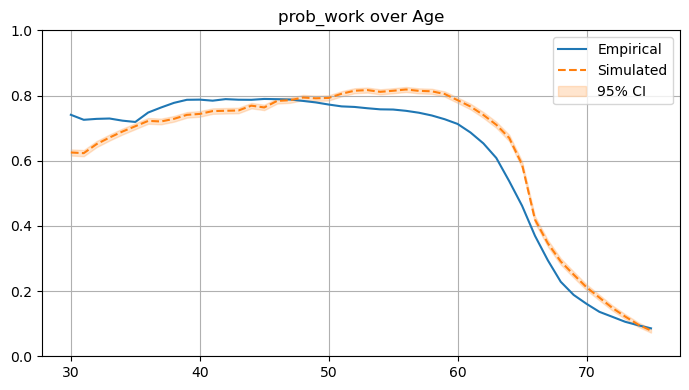

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_0_over_age_edu1.png


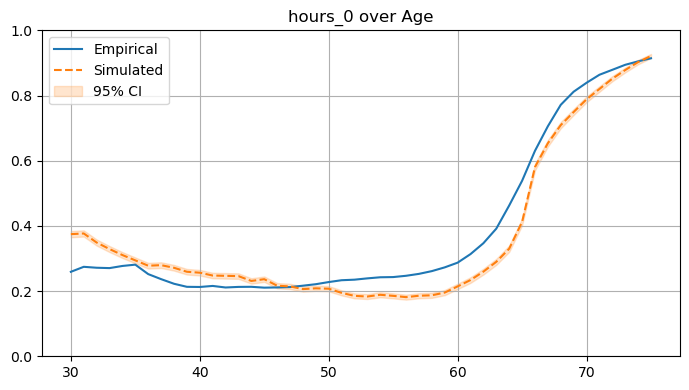

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_1_over_age_edu1.png


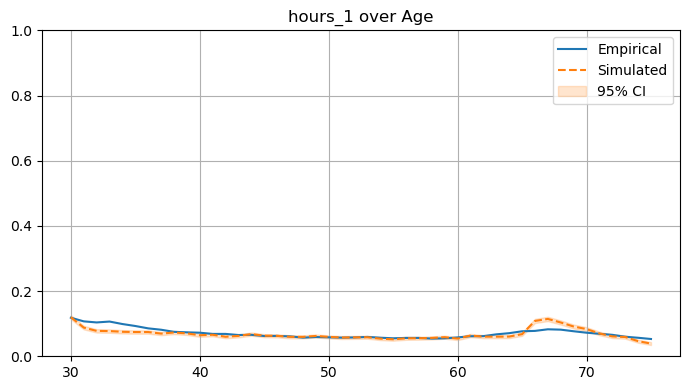

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_2_over_age_edu1.png


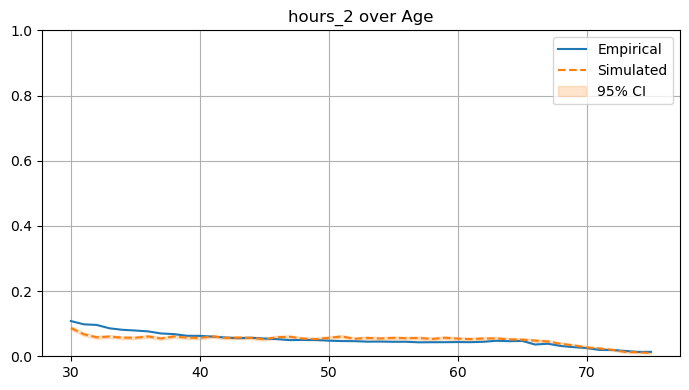

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_3_over_age_edu1.png


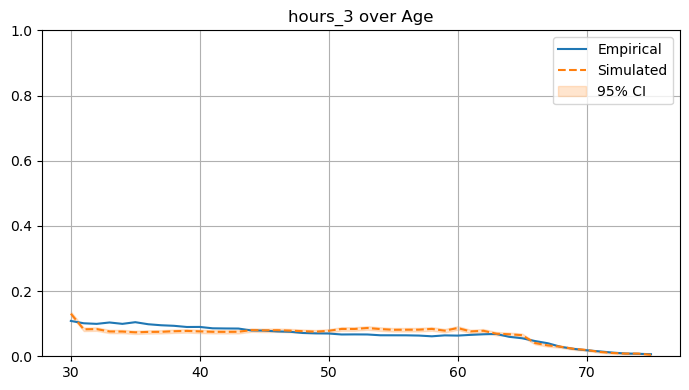

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_4_over_age_edu1.png


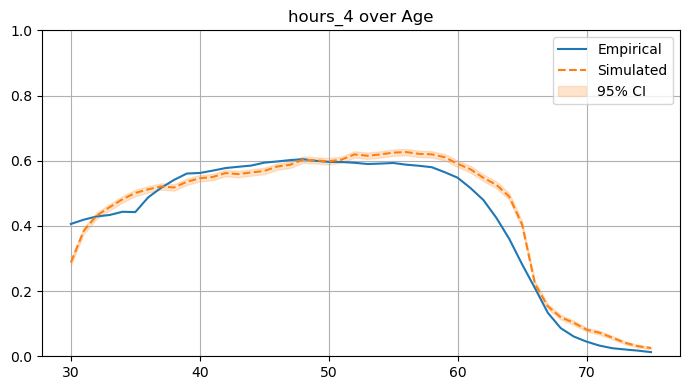

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_wealth_over_age_edu1.png


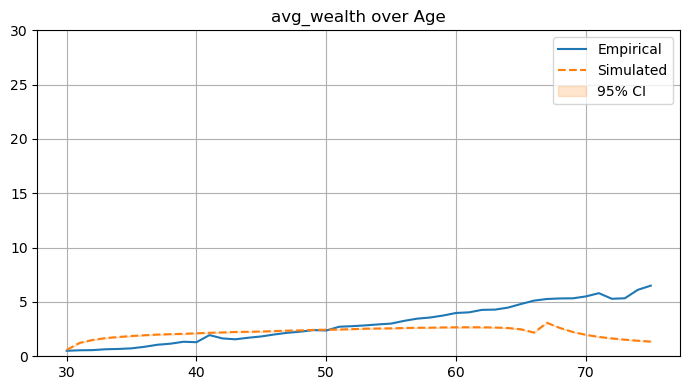

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/work_work_over_age_edu1.png


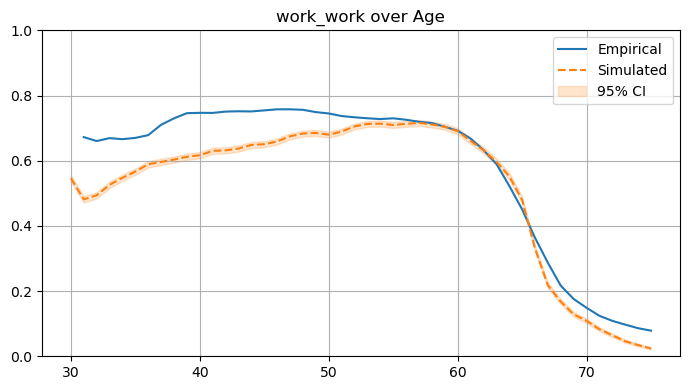

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/nowork_nowork_over_age_edu1.png


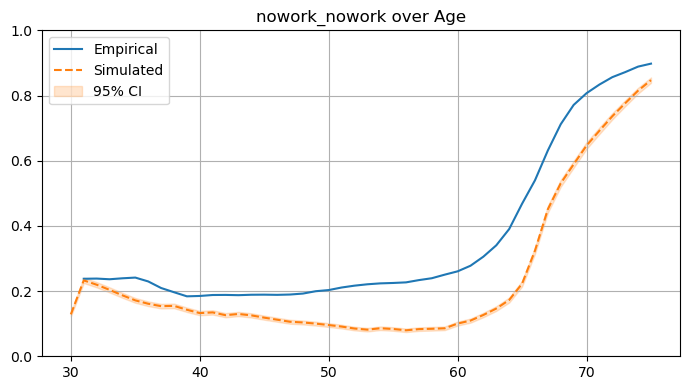

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_experience_over_age_edu1.png


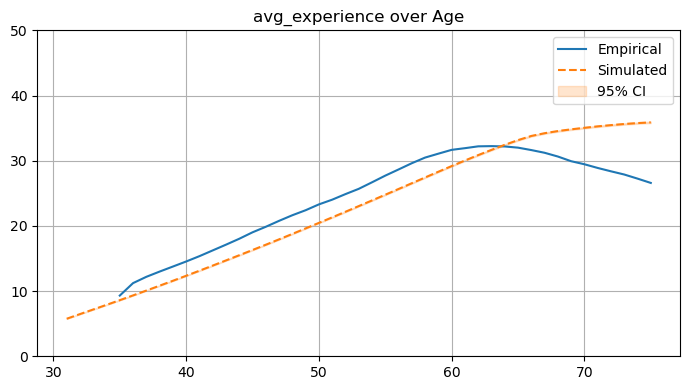

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_labor_income_over_age_edu1.png


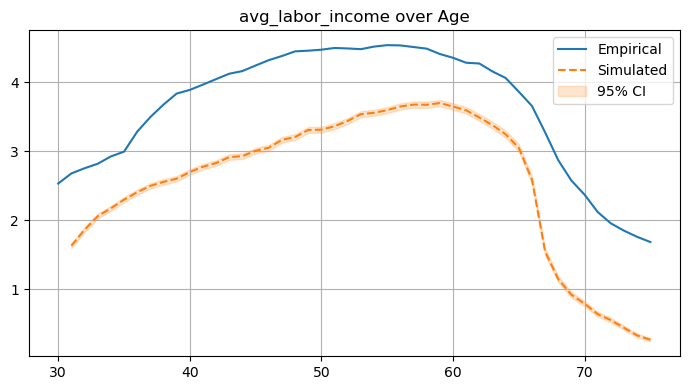

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_wage_over_age_edu1.png


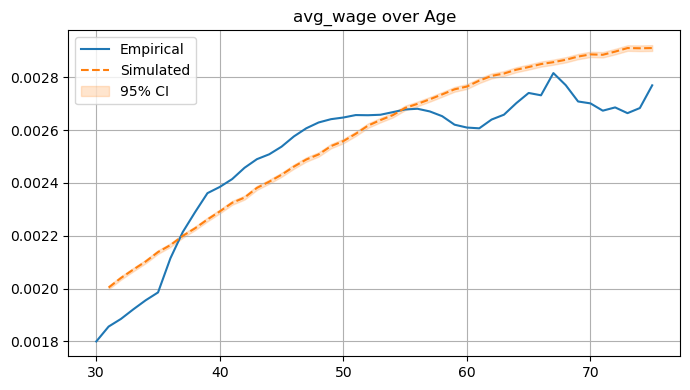

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_hours_over_age_edu1.png


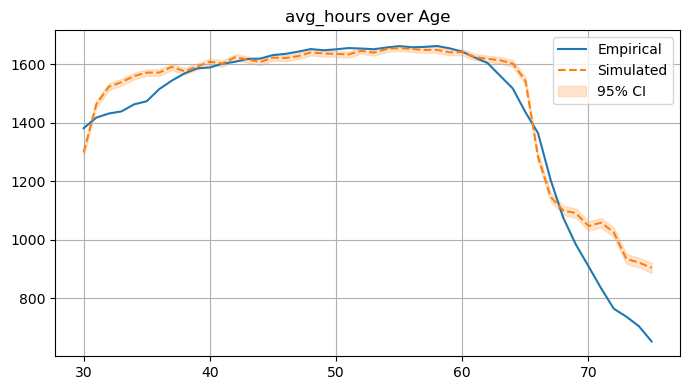

In [11]:
edu = df_edu_1.copy().loc[df_edu_1.age <= 75]       # empirical
moments_sim = compute_simulation_moments_with_ci(df_sim, start_age, hours_map)  # Call the function
moments_sim = moments_sim.loc[moments_sim.age <= 75]  # Filter simulated + CIs

# location to store plots in
BASE = "/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer"
# print plots
plot_empirical_vs_simulated_with_ci(edu, moments_sim, BASE, out_subfolder="edu1")
